In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 85% 103M/121M [00:00<00:00, 146MB/s] 
100% 121M/121M [00:01<00:00, 125MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import*
from keras.models import*
from keras.optimizers import*
from keras.utils import*
from keras.preprocessing.image import*
import os
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Display image sample**

In [6]:
img_size=48
f_path ="/content/images"

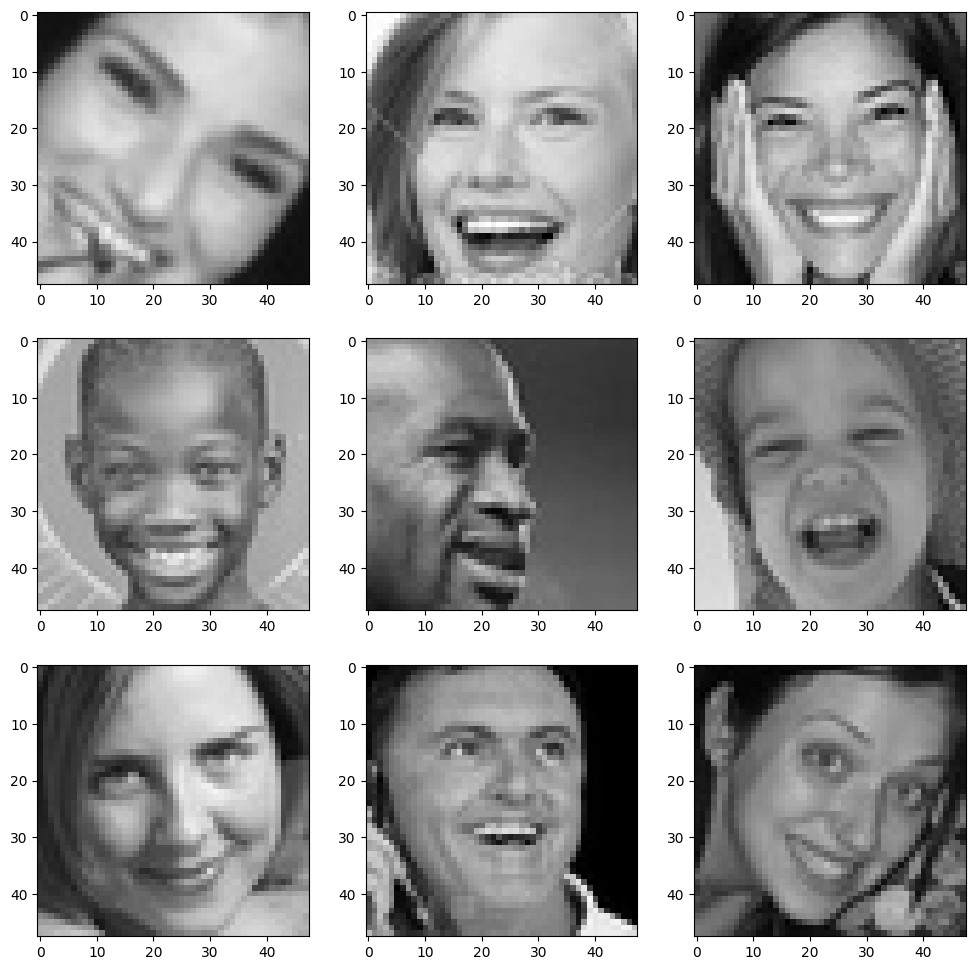

In [7]:
expression = 'happy'
plt.figure(figsize=(12,12))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(f_path +'/'+ 'train/'+ expression+ '/'+ os.listdir(f_path +'/'+ 'train/'+ expression)[i],target_size=(img_size,img_size))
  plt.imshow(img)
plt.show()

In [8]:
import cv2

In [9]:
img = cv2.imread('/content/images/images/train/angry/1.jpg')

In [10]:
img.shape

(48, 48, 3)

In [11]:
#generators are used to provide large set of data provided by keras
#as it is very diificult to process large set of data at one time
#because of insufficient memory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/images/train',
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    color_mode="rgb",                # Ensure images are in RGB format
    shuffle=True,                    # Shuffle the dataset for better training
    seed=42
)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/images/validation',
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    color_mode="rgb",                # Ensure images are in RGB format
    shuffle=False,                    # Shuffle the dataset for better training
    seed=42
)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [26]:
from tensorflow.keras import layers

# Apply normalization to the training dataset
normalized_train_ds = train_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# Apply normalization to the validation dataset
normalized_validation_ds = validation_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))


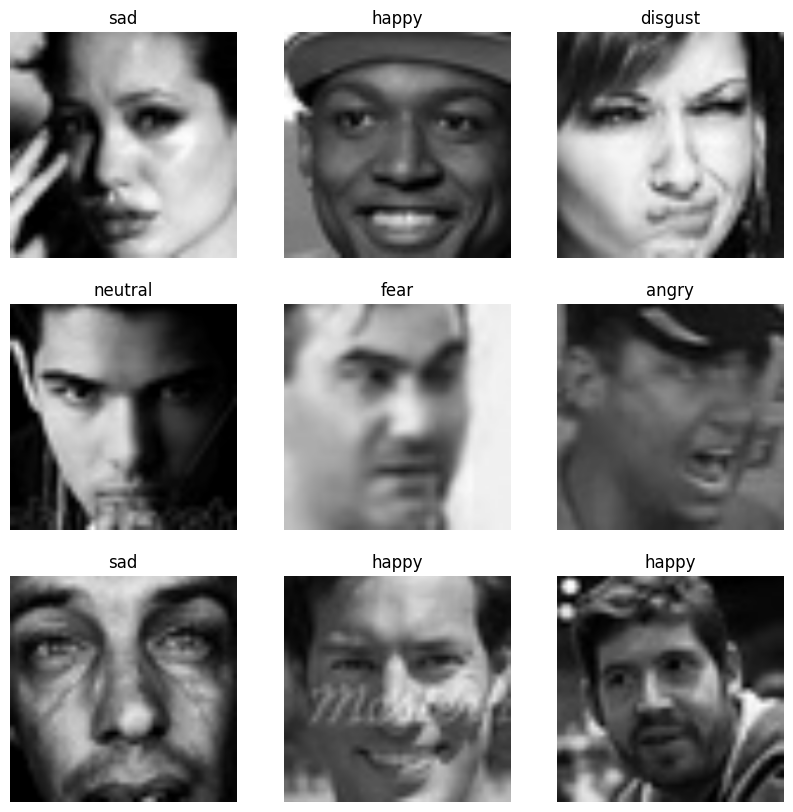

In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Retrieve a batch of images from the training dataset
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch from the dataset
    for i in range(9):  # Display 9 images in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert image tensor to uint8
        plt.title(class_names[tf.argmax(labels[i])])  # Display the label for each image
        plt.axis("off")  # Hide the axis
plt.show()

In [28]:
base_input=model.layers[0].input

In [29]:
base_output = model.layers[-2].output
base_output

<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, name=keras_tensor_365>

In [30]:
from keras.layers import*

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Load the base MobileNetV2 model without the top classification layer
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,              # Exclude the top classification layer
    weights='imagenet',             # Load weights pre-trained on ImageNet
    input_shape=(224, 224, 3)       # Input shape of the images
)

# Get the base model's input and output
base_input = base_model.input
base_output = base_model.output

# Flatten the output to prepare for Dense layers
x = layers.GlobalAveragePooling2D()(base_output)

# Add custom dense layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
final_output = layers.Dense(7, activation='softmax')(x)  # Final output layer for 7 classes

# Create the new model
new_model = Model(inputs=base_input, outputs=final_output)

# Print the new model summary
new_model.summary()


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,430,663 (9.27 MB)

 Trainable params: 2,396,551 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [32]:
new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
epochs=50

In [34]:
# Use the fit method directly with tf.data.Dataset objects
history = new_model.fit(
    x=normalized_train_ds,
    epochs=epochs,
    validation_data=normalized_validation_ds,
    callbacks=callbacks_list
)

Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4606 - loss: 1.4039
Epoch 1: val_accuracy improved from -inf to 0.27187, saving model to ./model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 179s 152ms/step - accuracy: 0.4607 - loss: 1.4038 - val_accuracy: 0.2719 - val_loss: 5.0298
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5818 - loss: 1.1065
Epoch 2: val_accuracy improved from 0.27187 to 0.40405, saving model to ./model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 155s 120ms/step - accuracy: 0.5818 - loss: 1.1065 - val_accuracy: 0.4040 - val_loss: 3.2407
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6166 - loss: 1.0212
Epoch 3: val_accuracy improved from 0.40405 to 0.42004, saving model to ./model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 142s 120ms/step - accuracy: 0.6166 - loss: 1.0212 - val_accuracy: 0.4200 - val_loss: 3.3808
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6399 - loss: 0.9639
Epoch 4: val_accuracy did not 

**Model Building**

In [37]:
new_model.save('Mymodel.keras')

In [38]:
new_model= tf.keras.models.load_model('Mymodel.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 164 variables whereas the saved optimizer has 326 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:
t_img=cv2.imread('/content/download11.jpeg')

In [58]:
t_img.shape

(183, 275, 3)

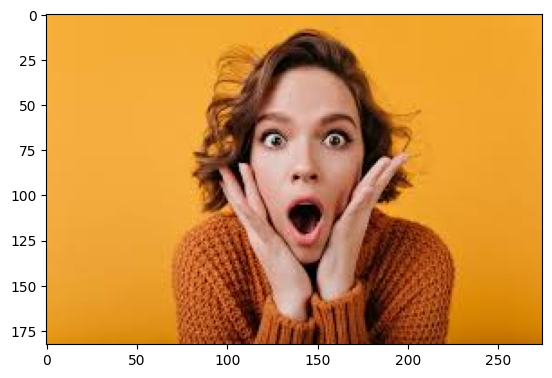

In [59]:
plt.imshow(cv2.cvtColor(t_img,cv2.COLOR_BGR2RGB))

In [60]:
gray_img = cv2.cvtColor(t_img,cv2.COLOR_BGR2GRAY)

array([[184, 184, 184, ..., 181, 181, 181],
       [184, 184, 184, ..., 181, 181, 181],
       [184, 184, 184, ..., 181, 181, 181],
       ...,
       [159, 159, 158, ..., 130, 130, 130],
       [157, 157, 157, ..., 129, 129, 129],
       [156, 156, 156, ..., 127, 127, 127]], dtype=uint8)
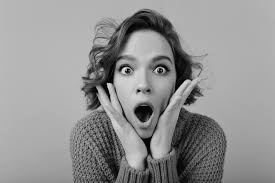

In [61]:
gray_img

In [62]:
face_classifier = cv2.CascadeClassifier(r'/content/haarcascade_frontalface_default.xml')

In [63]:
faces = face_classifier.detectMultiScale(t_img,1.1,4)
for (x,y,w,h) in faces:

    roi_gray = gray_img[y:y+h,x:x+w]
    roi_color = t_img[y:y+h,x:x+w]
    cv2.rectangle(t_img,(x,y),(x+w,y+h),(0,255,255),2)
    facess = face_classifier.detectMultiScale(roi_gray)
    if len(facess) == 0:
      print('Face Not Detected')
    else:
      for ex,ey,ew,eh in facess:
        face_roi = roi_color[ey:ey+eh,ex:ex+ew]
    # roi_gray = cv2.resize(roi_gray,(224,224),interpolation=cv2.INTER_AREA)


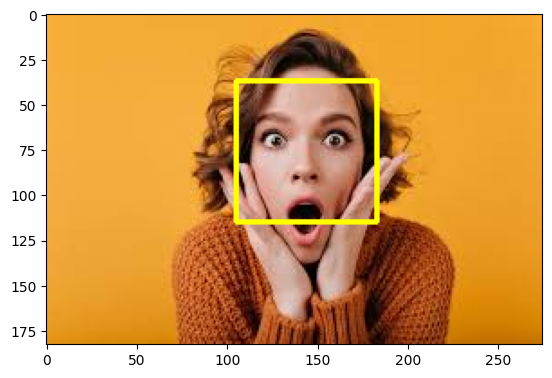

In [64]:
plt.imshow(cv2.cvtColor(t_img,cv2.COLOR_BGR2RGB))

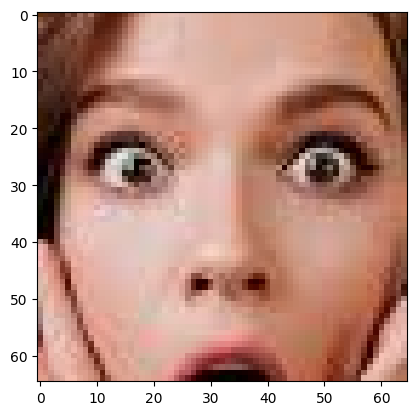

In [65]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [66]:
final_img = cv2.resize(face_roi,(224,224))
final_img = np.expand_dims(final_img,axis=0)
final_img = final_img/255.0

In [67]:
predictions=new_model.predict(final_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [68]:
predictions[0]

array([7.9874729e-09, 1.0467468e-07, 7.2998513e-04, 1.4673408e-07,
       1.0795219e-09, 7.1247154e-11, 9.9926978e-01], dtype=float32)

In [69]:
np.argmax(predictions)

6

**Realtime Video Demo**

In [79]:
import cv2
import numpy as np
import tensorflow as tf

# Load the pre-trained Haar Cascade for face detection
face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

# Define font and colors
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5
rectangle_bgr = (255, 255, 255)

# Initialize the webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Cannot open webcam')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_classifier.detectMultiScale(gray_img, 1.1, 4)

    # Iterate over detected faces
    for (x, y, w, h) in faces:
        roi_gray = gray_img[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)

        # Prepare the face ROI for prediction
        face_roi = cv2.resize(roi_color, (224, 224))
        face_roi = np.expand_dims(face_roi, axis=0) / 255.0

        # Predict emotion
        predictions = new_model.predict(face_roi)
        emotion_label = np.argmax(predictions)

        # Map prediction to emotion labels
        emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
        status = emotion_map.get(emotion_label, 'Unknown')

        # Draw status box and emotion text
        cv2.putText(frame, status, (x, y-10), font, font_scale, (0, 0, 255), 2)

    # Display the frame
    cv2.imshow('Emotion Detector', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


OSError: Cannot open webcam

**Fitting the Model with Training and Validation**

**Plotting Accuracy and Loss**

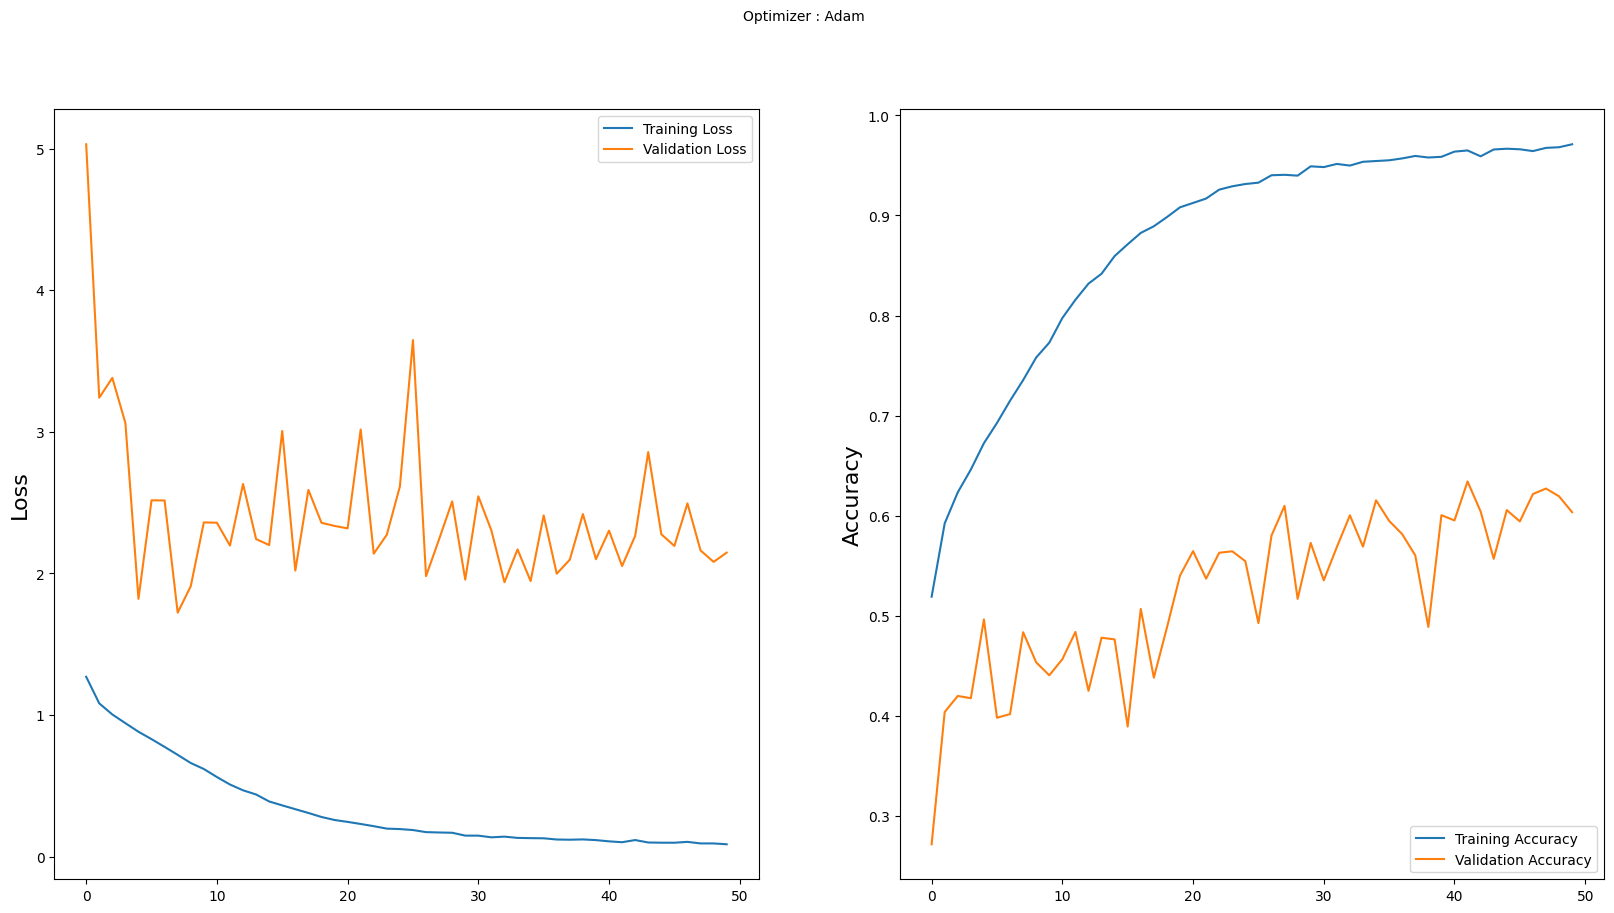

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()